<a href="https://colab.research.google.com/github/linked0/deep-learning/blob/master/AAMY/Classifying_Images_of_Clothing_my.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###### Google Colaboration ####    
# google drive 접속
from google.colab import drive
drive.mount('/content/drive')
!ln -s  'drive/My Drive' mydrive
!ls mydrive

###### file downlaod
from google.colab import files
#files.download(white_output)
 
###### git partially cloning
repo='cvnd-exercises'
sub_dir='1_2_Convolutional_Filters_Edge_Detection'
url='https://github.com/linked0/' + repo + '.git'
!mkdir $repo
%cd $repo
!git init
!git remote add -f origin $url
!git config core.sparsecheckout true
!echo $sub_dir >> .git/info/sparse-checkout
!git pull --recurse-submodules origin master
%cd $sub_dir
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'20190326_회의록_인프라 구성 협의.docx'
'20190401_회의록_블록체인 개발 회의.pdf'
 APIWAS연동인터페이스정의_v0.1.pdf
 a-reference
'~$블록체인 송수신자료_As-Is.xlsx'
'블록체인 송수신자료_As-Is.xlsx'
 backup
 backup-source
 BCCARD_시스템구성도_v0.1.pptx
'BC카드 블록체인 정산시스템_시스템구성도_변경안_v01_20190328.pptx'
'BC카드 블록체인 정산시스템_시스템구성도_수정안_v02_20190401.pdf'
 book-doc-music
'Colab Notebooks'


In [2]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 686kB 2.9MB/s 


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

# This will go away in the future
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataet = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('NUmber of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

NUmber of training examples: 60000
Number of test examples: 10000


## Preprocess the data
The value of each pixel in the image data is an integer in the range [0, 255]. For the model to work properly, these values need to be normalized to the range [0, 1]. So here we create a normalization funciton, and then apply it to each image in the test and train datasets.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataet
test_dataset = test_dataset.map(normalize)


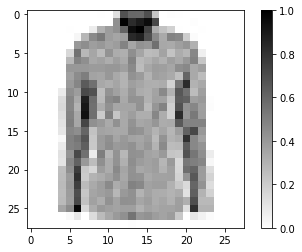

In [8]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# plot the image -  voila a piece of fashin clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

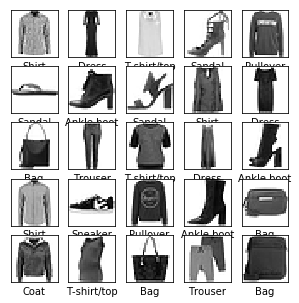

In [9]:
plt.figure(figsize=(5,5))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

## Build the model

### Setup the layers
The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representaion that is meaningful for the problem at hand.
Much of deep learning consists of chaining together simple layers. Most layseers, like tf.keras.layers.Dense, have internal parameters which are adjusted ("learned") during training.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

The network ahs theree layers:
* **input** `tf.keras.layers.Flatten` - This layer transforms the images form a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels(28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformates the data.

* **"hidden"** `tf.keras.layers.Dense` - A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `tf.keras.layers.Dense` - A 10-node *softmax* layer, with each node representing a class of clothin As in the previous layer, each node takes input form the 128 nodes in the layer before it. Each node wieghts the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

### Compile the model
Befor the mode is ready for training, it needs a few more setting. These are added during the model's *compile* step:

* *Loss function* - An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer*  - An algorithms for adusting the inner parameters of model in order to minimize loss.
* *Metrics* - Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model
First, we define the iteration behavior for the train dataset:
1. Rpeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we performa training)
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Traiining is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so total of 5 * 60000 = 300000 examples

(Don't worry about `steps_per_epoch`, the requriement to have this flag will soon be removed)

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))


Epoch 1/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4980 - acc: 0.8266
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3670 - acc: 0.8683
Epoch 3/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3338 - acc: 0.8795
Epoch 4/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3158 - acc: 0.8848
Epoch 5/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2917 - acc: 0.8918


## Evaluate accuracy
Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.


AS the model trains, the loass and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset: ', test_accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.3571 - acc: 0.8713
Accuracy on test dataset:  0.8713


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the test_dataset), we can expect performace to go down.

## Make predictions and explore
With the model trained, we can use it to make predictions about some images

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [18]:
predictions[0]

array([7.8706449e-05, 1.7524014e-08, 1.8254716e-02, 1.9568766e-05,
       5.9591848e-02, 1.0395797e-07, 9.2205334e-01, 1.5492328e-10,
       1.6321035e-06, 5.5311555e-09], dtype=float32)

In [19]:
np.argmax(predictions[0])

6

In [20]:
test_labels[0]

6

We can graph tis to look at the full set of 10 channels

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[..., 0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100*np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color='#777777')
  plt.ylim([0,1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

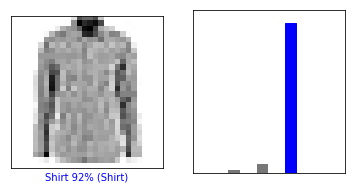

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

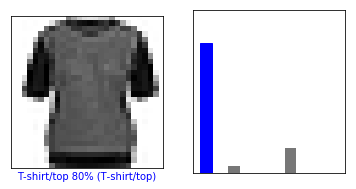

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

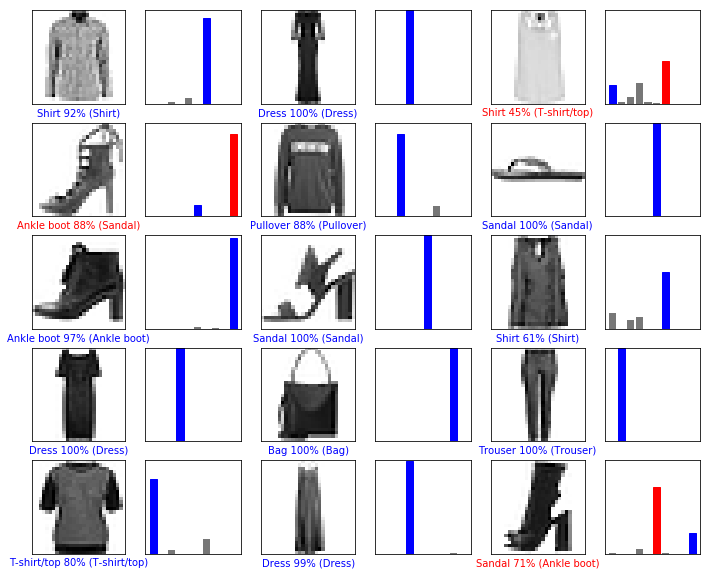

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [29]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [30]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [31]:
predictions_single = model.predict(img)
print(predictions_single)

[[7.8706311e-05 1.7523949e-08 1.8254695e-02 1.9568732e-05 5.9591800e-02
  1.0395808e-07 9.2205346e-01 1.5492300e-10 1.6320990e-06 5.5311458e-09]]


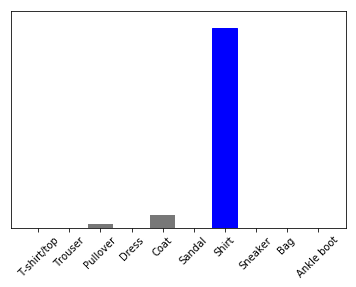

In [32]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [34]:
np.argmax(predictions_single[0])

6